In [1]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from utils.data_utils import *
from model.encoder import Encoder
from model.generator import Generator
from model.discriminator import Discrimator

import matplotlib.pyplot as plt

In [2]:
def weight_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv3d') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

# Args

In [3]:
choose_cuda = True
data_dir = '/home/ewok261/Documents/psychic-gan/data/in_2_out_1_ol_0_skips'
frm_in = 2
frm_out = 1
mini_batch = 4
n_epochs = 200

In [4]:
if choose_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Load data

In [5]:
all_data = KITTIData(frm_in, frm_out, 0, data_dir)
[train_data,val_data] = data.random_split(all_data, [1100, 200])
[train_data, _] = data.random_split(train_data, [10, 1090]) # take a small subset of training data (for overfitting)
[val_data, _] = data.random_split(val_data, [30, 170])
train_loader = data.DataLoader(train_data, batch_size = mini_batch, shuffle=True, num_workers=1)
val_loader = data.DataLoader(val_data, batch_size = 1, shuffle = False, num_workers = 1)
print('Train size: {0}'.format(len(train_data)))
print('Val size: {0}'.format(len(val_data)))

Train size: 10
Val size: 30


# Define the network and loss

In [6]:
loss_fun = nn.MSELoss()

encoder = Encoder(frame_dim=64, init_temp=2, hidden_dim=128, out_filters=256,
                  attention_at=16, norm=nn.utils.weight_norm, residual=True)
encoder = encoder.to(device)
encoder_optim = optim.Adam(encoder.parameters(), betas=(0.9, 0.999))

generator = Generator(frame_dim=64, temporal_target=1, hidden_dim=128,
                      init_filters=256, attention_at=32, norm=nn.utils.weight_norm)
generator = generator.to(device)
generator_optim = optim.Adam(generator.parameters(), betas=(0.9, 0.999))

encoder.apply(weight_init)
generator.apply(weight_init)

#summary(encoder, input_size=(3, frm_in, 64, 64))
#summary(generator, input_size=(128,))

Generator(
  (linear): Linear(in_features=128, out_features=4096, bias=True)
  (up_stack): ModuleList(
    (0): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (upsample): Upsample(size=(1, 8, 8), mode=nearest)
        )
      )
    )
    (1): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (upsample): Upsample(size=(1, 16, 16), mode=nearest)
        )
      )
    )
    (2): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

In [7]:
print(encoder)
print(generator)

Encoder(
  (linear): Linear(in_features=8192, out_features=128, bias=True)
  (down_stack): ModuleList(
    (0): ResidualNormConv3D(
      (layer): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
        )
      )
      (layer_1): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(3, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        )
      )
    )
    (1): ResidualNormConv3D(
      (layer): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
        )
      )
      (layer_1): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(32, 64, kernel_size=(1, 1, 1), s

# Training loop

In [8]:
train_hist_real = []
train_hist_gen = []
val_hist = []
for epoch in range(n_epochs):
        running_loss_gen = 0.0
        running_loss_real = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs and move them to device
            in_frames, out_frames = data
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # zero the parameter gradients
            encoder.zero_grad()
            generator.zero_grad()
            
            # GENERATOR/ENCODER TRAINING
            hidden, encoder_attn = encoder(in_frames)
            generated, generator_attn = generator(hidden)
            
            loss_gen = loss_fun(generated, out_frames)
            
            loss_gen.backward()
            encoder_optim.step()
            generator_optim.step()

            # print statistics
            running_loss_gen += loss_gen.item() / 3
            if i % 3 == 2:
                print('[Epoch {0} - Step {1}] R-loss: {2} G-loss: {3}'.format(epoch, i, running_loss_real, running_loss_gen))
                train_hist_real.append(running_loss_real)
                train_hist_gen.append(running_loss_gen)
                running_loss_real = 0
                running_loss_gen = 0

        val_loss = 0.0
        for in_frames, out_frames in val_loader:
            # get the validation inputs and outputs
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # forward
            with torch.no_grad():
                hidden, encoder_attn = encoder(in_frames)
                generated, generator_attn = generator(hidden)
            
            val_loss += loss_fun(generated, out_frames).item() / len(val_loader)
            #val_loss += loss_fun(generated, out_frames).item() / len(val_loader)

        print('[Epoch {0}] Val-Loss: {1}'.format(epoch, val_loss))
        val_hist.append(val_loss)

[Epoch 0] Val-Loss: 0.14501252360641953
[Epoch 1] Val-Loss: 0.14404360021774965
[Epoch 2] Val-Loss: 0.12086505591869355
[Epoch 3] Val-Loss: 0.10339961995681125
[Epoch 4] Val-Loss: 0.08630458116531371
[Epoch 5] Val-Loss: 0.08644322336961824
[Epoch 6] Val-Loss: 0.08412016220390796
[Epoch 7] Val-Loss: 0.08429707462588946
[Epoch 8] Val-Loss: 0.08951967072983583
[Epoch 9] Val-Loss: 0.09528799653053284
[Epoch 10] Val-Loss: 0.0946071336666743
[Epoch 11] Val-Loss: 0.09173368588089943
[Epoch 12] Val-Loss: 0.08895829257865749
[Epoch 13] Val-Loss: 0.08743850775063036
[Epoch 14] Val-Loss: 0.08508440256118772
[Epoch 15] Val-Loss: 0.08840049703915911
[Epoch 16] Val-Loss: 0.08202387789885203
[Epoch 17] Val-Loss: 0.08357703909277918
[Epoch 18] Val-Loss: 0.07578014936298133
[Epoch 19] Val-Loss: 0.07158886122827728
[Epoch 20] Val-Loss: 0.07171369877954324
[Epoch 21] Val-Loss: 0.07020505610853434
[Epoch 22] Val-Loss: 0.0709099493920803
[Epoch 23] Val-Loss: 0.0678981168816487
[Epoch 24] Val-Loss: 0.065588

[Epoch 198] Val-Loss: 0.06918157680581014
[Epoch 199] Val-Loss: 0.06850535534322262


# Results visualization

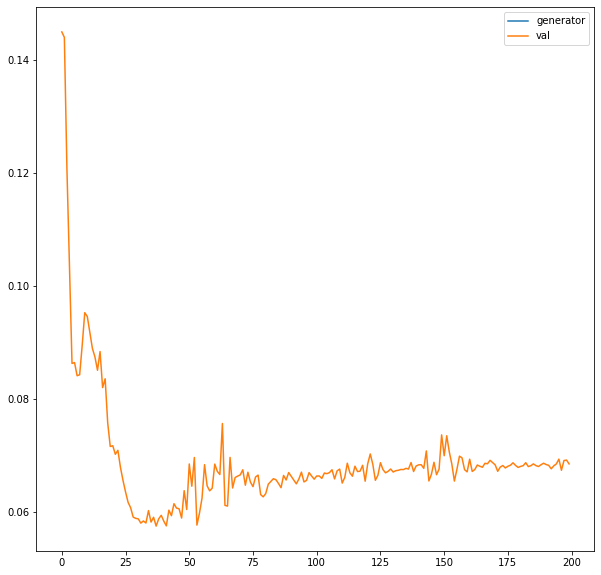

In [9]:
plt.figure(figsize=(10, 10))
plt.plot(train_hist_gen)
plt.plot(val_hist)
plt.legend(['generator', 'val'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 2, 64, 64])
torch.Size([1, 3, 1, 64, 64])


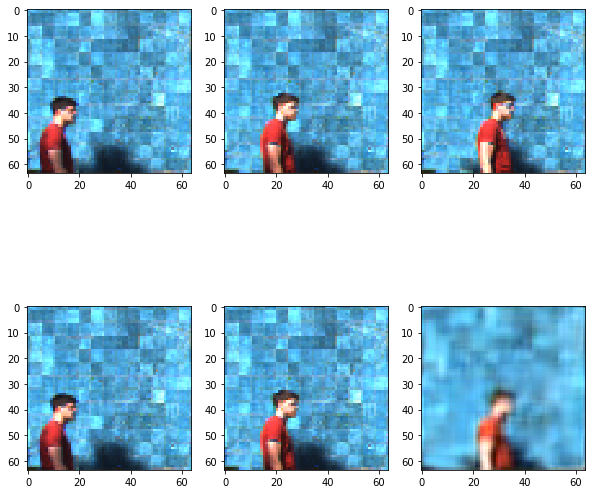

In [10]:
insamp, outsamp = train_data[0]
insamp = insamp.unsqueeze(0)
outsamp = outsamp.unsqueeze(0)
print(insamp.shape)
print(outsamp.shape)
insamp, outsamp = insamp.to(device), outsamp.to(device)

with torch.no_grad():
    hidval, encval_attn = encoder(insamp)
    genval, genval_attn = generator(hidval)

insamp = insamp.cpu().squeeze().permute(1,2,3,0).numpy()
genval = genval.cpu().squeeze().permute(1,2,0).detach().numpy()
outsamp = outsamp.cpu().squeeze().permute(1,2,0).numpy()

plt.figure(figsize=(10, 10))
# img
plt.subplot(2, frm_in+frm_out, 1)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 2)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 3)
plt.imshow(outsamp)

# target
plt.subplot(2, frm_in+frm_out, 4)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 5)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 6)
plt.imshow(genval)
plt.show()

In [11]:
encval_attn = encval_attn.cpu().squeeze().detach().numpy()
genval_attn = genval_attn.cpu().squeeze().detach().numpy()
print(encval_attn.shape)
print(genval_attn.shape)

(2, 16, 16, 2, 16, 16)
(32, 32, 32, 32)


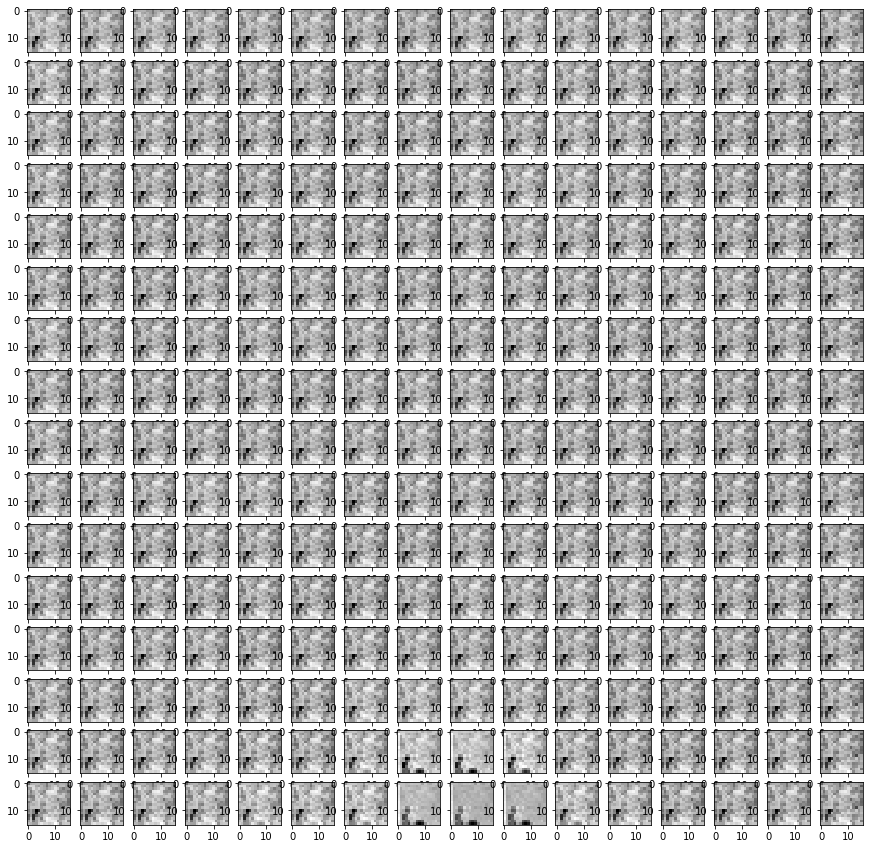

In [20]:
plt.figure(figsize=(15, 15))
act_tens = encval_attn
for idx in range(act_tens.shape[1]):
    for idy in range(act_tens.shape[2]):
        plt.subplot(act_tens.shape[1], act_tens.shape[2], idy + idx*act_tens.shape[1] + 1)
        plt.imshow(act_tens[1,idx,idy,0,:,:], cmap = 'gray')
plt.show()

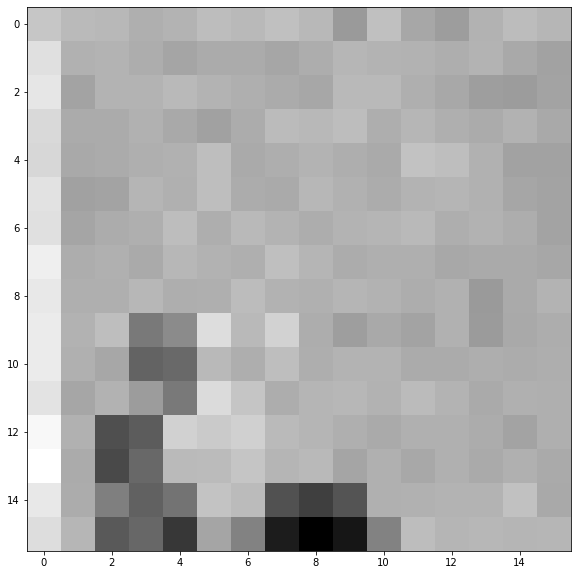

(array([ 5, 11,  2,  8, 14,  9, 10,  7, 12, 13]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


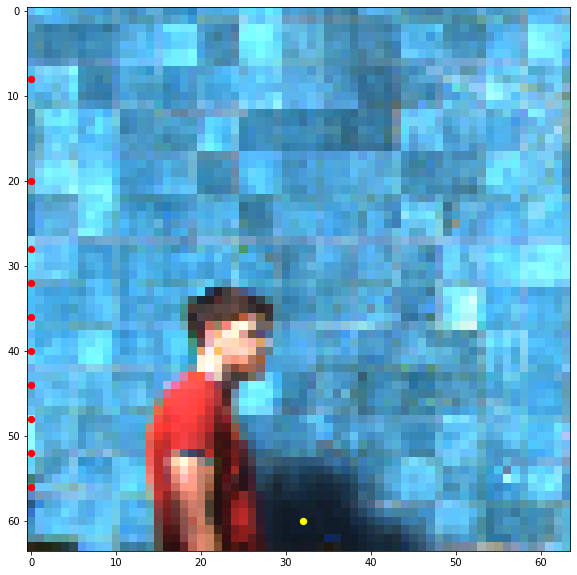

In [32]:
orig_x = 60
orig_y = 32
plt.figure(figsize=(10, 10))
plt.imshow(encval_attn[1,orig_x // 4, orig_y // 4, 0, :, :], cmap = 'gray')
plt.show()

top_attn = encval_attn[1, orig_x // 4, orig_y // 4, 0, :, :]
idx = np.argsort(top_attn,axis = None)[-10:]
midx = np.unravel_index(idx, top_attn.shape)

print(midx)

plt.figure(figsize=(10, 10))
plt.imshow(insamp[1])
plt.scatter([x*4 for x in midx[1]], [x*4 for x in midx[0]], color='red', s=40)
plt.scatter(orig_y, orig_x, color='yellow', s=40)
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))
act_tens = genval_attn
for idx in range(0,8):
    for idy in range(0,8):
        plt.subplot(8, 8, idy + idx*8 + 1)
        plt.imshow(act_tens[idx+16,idy,:,:], cmap = 'gray')
plt.show()

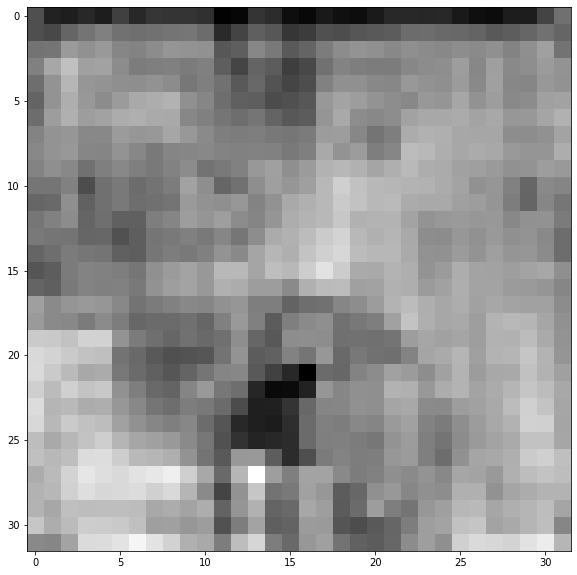

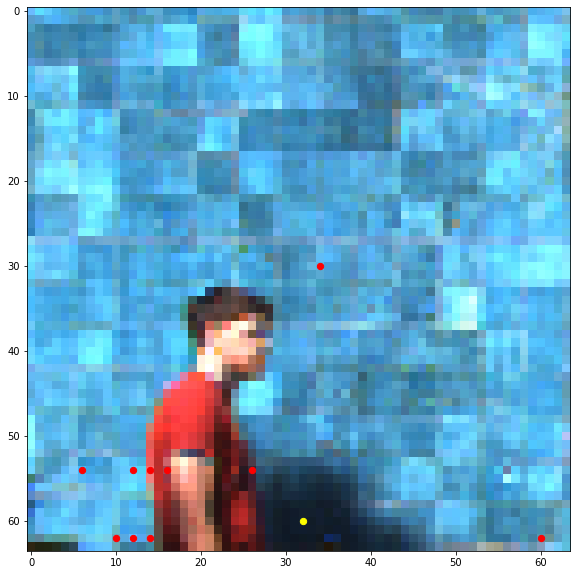

In [38]:
orig_x = 60
orig_y = 32
plt.figure(figsize=(10, 10))
plt.imshow(genval_attn[orig_x // 2, orig_y // 2, :, :], cmap = 'gray')
plt.show()

top_attn = genval_attn[orig_x // 2, orig_y // 2, :, :]
idx = np.argsort(top_attn,axis = None)[-10:]
midx = np.unravel_index(idx, top_attn.shape)

plt.figure(figsize=(10, 10))
plt.imshow(insamp[1])
plt.scatter([x*2 for x in midx[1]], [x*2 for x in midx[0]], color='red', s=40)
plt.scatter(orig_y, orig_x, color='yellow', s=40)
plt.show()